#What is  image segmentation:
Image segmentation is a fundamental technique in computer vision that involves partitioning an image into distinct regions or objects based on their shared characteristics.

# Mean Shift Segmentation
Mean Shift is a non-parametric clustering algorithm widely used for image segmentation. It identifies clusters by iteratively shifting data points toward regions of higher density, making it effective for segmenting images based on pixel intensity and color.
In other, words mean shift segmentation is a way of grouping similar pixels together automatically by letting the computer “feel its way” toward areas where pixels are most alike.
Example.
Imagine a crowd of people standing on a field. People naturally move toward groups where others are wearing similar clothes. Eventually, small groups form without anyone telling them how many groups there should be.
That's mean shift: pixels move toward the most similar neighbors until clear groups appear.


##Strengths

###No prior knowledge of number of regions needed
Unlike k-means, you don't need to specify the number of clusters.

###Good edge preservation.
It naturally respects object boundaries.

###Robust to noise.
The averaging process smooths out small variations.

###Handles complex shapes.
Can segment arbitrarily shaped regions.

###Combines spatial and color information.
Leads to more visually meaningful segments.

##Limitations
### Computationally expensive.
  Slow for large or high-resolution images.
###Sensitive to bandwidth parameters.
  Poor choice of bandwidth leads to over- or under-segmentation.
###Memory intensive.
Needs to store feature vectors for all pixels.
###Not ideal for real-time applications.
Unless optimized or approximated.

## Applications

1.  Object and region segmentation in natural images.
2.  Medical image analysis (e.g., tissue segmentation).
3.  Video tracking and background substraction.
4.  Image smoothing and denoising.
5.  Computer vision preprocessing tasks.



# Split and Merge
Split and merge segmentation is a region-based image processing technique used to divide an image into meaningful regions based on a homogeneity criterion. It involves two main phases: splitting the image into smaller regions and merging adjacent regions that meet the homogeneity condition. This method is commonly implemented using a quadtree data structure, where the image is recursively divided into quadrants.In other words it is a method where the computer cuts an image into pieces, checks if each piece looks the same inside, and then joins pieces back together if they match.

Example: Sorting laundry into a waredrop.
You dump all your clothes on the bed.
First, you split them into small piles randomly.
You check each pile:
Are these all white?
Are these all jeans?
If two piles look the same, you merge them.
If a pile has mixed clothes, you split it again.
After sorting you pack them accordinly in the waredrop.

##Strengths

###Conceptually simple and intuitive.

###Good for region homogeneity.
Works well when regions have uniform properties.

###Flexible segmentation.
Combines both top-down (splitting) and bottom-up (merging) approaches.

###Structured representation.
Quadtree makes spatial relationships easy to manage.

##Limitations

###Blocky or unnatural boundaries.
Segments are often square-shaped.

###Sensitive to homogeneity threshold.
Wrong threshold gives poor segmentation.

###Poor edge localization.
Does not precisely follow object boundaries.

###Not effective for textured or noisy images.

###May over-segment uniform areas initially.

##Applications

1.  Document image segmentation.

2.  Satellite and aerial image analysis.

3.  Medical imaging (large uniform regions).

4.  Simple scene analysis.

5.  Educational and research demonstrations of region-based methods.

In [ ]:
#Mean shift segmentation


In [ ]:
# Split and Merge

Original image shape: (512, 512, 3)
Flattened image shape: (262144, 3)
Estimated bandwidth: 0.26852559694951605
Number of estimated clusters: 3


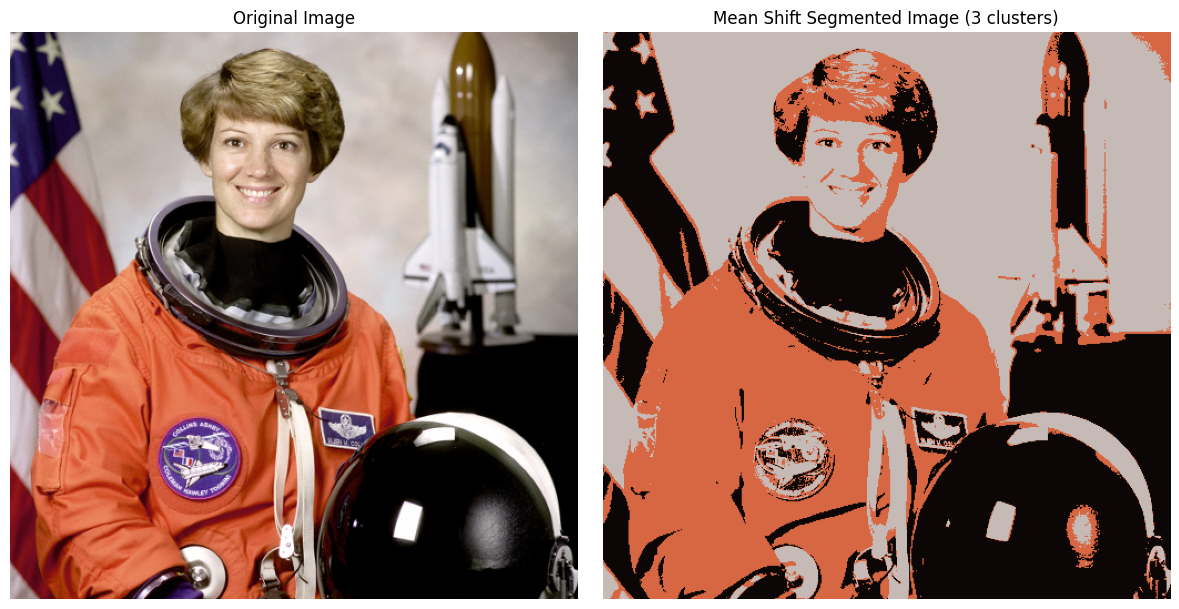

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color
from sklearn.cluster import MeanShift, estimate_bandwidth

# Load a sample image (you can replace this with your own image path)
# For demonstration, we'll create a simple synthetic image or use a common one if available.
# Let's try to load a sample image from skimage data or create one.
try:
    from skimage import data
    image = data.astronaut()
    image = image.astype(float) / 255
except ImportError:
    print("scikit-image data not found, creating a simple synthetic image.")
    # Create a simple synthetic image if skimage.data is not available
    image = np.zeros((100, 100), dtype=np.uint8)
    image[20:80, 20:80] = 150
    image[40:60, 40:60] = 250

print(f"Original image shape: {image.shape}")

# Reshape the image to be a list of pixels (features)
# If the image is grayscale, it's (height * width, 1)
# If the image is RGB, it's (height * width, 3)
if image.ndim == 2:
    flat_image = image.reshape((-1, 1))
else: # Assuming RGB or RGBA
    flat_image = image.reshape((-1, image.shape[-1]))

print(f"Flattened image shape: {flat_image.shape}")

# Estimate bandwidth for Mean Shift. This is crucial for performance and result quality.
# The 'quantile' parameter specifies the fraction of samples to query for bandwidth estimation.
# A smaller quantile will result in a smaller bandwidth and potentially more clusters.
bandwidth = estimate_bandwidth(flat_image, quantile=0.2, n_samples=500)

print(f"Estimated bandwidth: {bandwidth}")

# Perform Mean Shift clustering
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(flat_image)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

n_clusters_ = len(np.unique(labels))
print(f"Number of estimated clusters: {n_clusters_}")

# Create the segmented image by replacing each pixel with its cluster center color
segmented_image = cluster_centers[labels].reshape(image.shape)

# Display the original and segmented images
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray' if image.ndim == 2 else None)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(segmented_image.astype(image.dtype), cmap='gray' if image.ndim == 2 else None) # Ensure dtype matches for display
plt.title(f'Mean Shift Segmented Image ({n_clusters_} clusters)')
plt.axis('off')

plt.tight_layout()
plt.show()


Image not found or error loading with OpenCV. Creating a more interesting synthetic image for demonstration.
Original image shape: (200, 200)
Number of regions after splitting: 571


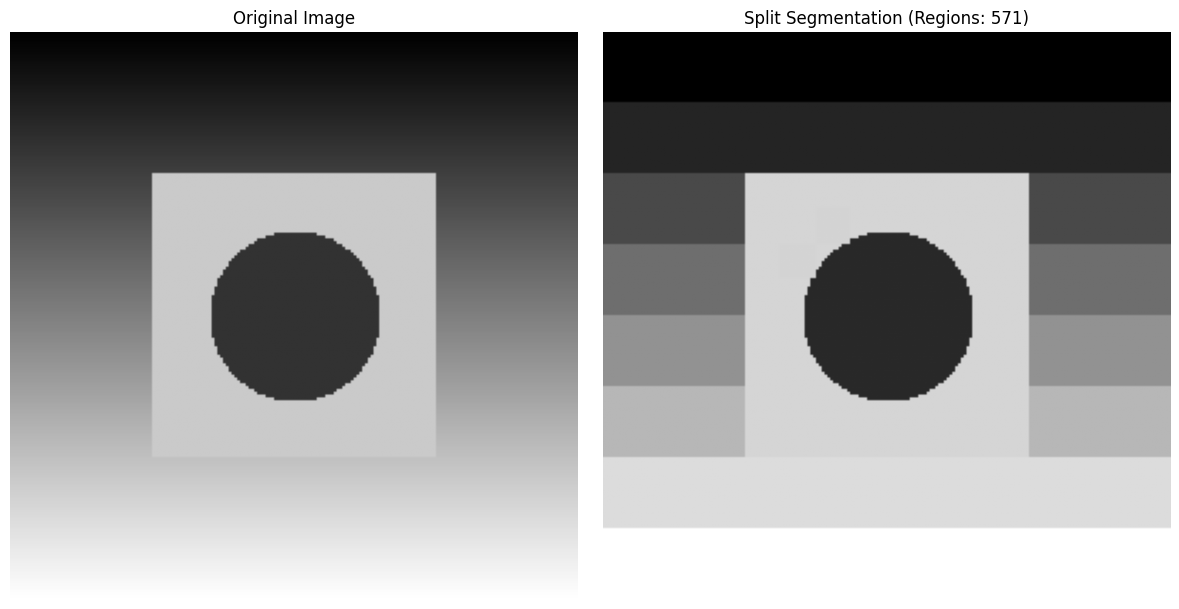

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 # Changed from skimage

def is_homogeneous(region, threshold=10):
    """
    Checks if a region is homogeneous based on standard deviation.
    A smaller threshold means more strict homogeneity.
    """
    if region.size == 0:
        return True
    return np.std(region) < threshold

def split_and_label(image, region_coords, labels, current_label, threshold=10):
    """
    Recursively splits the image into homogeneous regions and assigns labels.
    region_coords: (r_start, r_end, c_start, c_end)
    """
    r_start, r_end, c_start, c_end = region_coords
    region = image[r_start:r_end, c_start:c_end]

    # Stop splitting if region is homogeneous or too small
    if is_homogeneous(region, threshold) or (r_end - r_start <= 1 and c_end - c_start <= 1):
        labels[r_start:r_end, c_start:c_end] = current_label
        return current_label + 1
    else:
        # Split into 4 quadrants
        mid_r = (r_start + r_end) // 2
        mid_c = (c_start + c_end) // 2

        next_label = current_label
        # Top-left
        next_label = split_and_label(image, (r_start, mid_r, c_start, mid_c), labels, next_label, threshold)
        # Top-right
        next_label = split_and_label(image, (r_start, mid_r, mid_c, c_end), labels, next_label, threshold)
        # Bottom-left
        next_label = split_and_label(image, (mid_r, r_end, c_start, mid_c), labels, next_label, threshold)
        # Bottom-right
        next_label = split_and_label(image, (mid_r, r_end, mid_c, c_end), labels, next_label, threshold)
        return next_label

# Load a sample image using OpenCV
try:
    # Attempt to load a common test image with OpenCV as grayscale
    image_path = 'IMG_2222.PNG' # Replace with a valid image path
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise FileNotFoundError(f"{image_path} not found. Creating a synthetic image.")
except (FileNotFoundError, cv2.error):
    print("Image not found or error loading with OpenCV, creating a simple synthetic image.")
    # Create a simple synthetic grayscale image if file not found
    image = np.zeros((100, 100), dtype=np.uint8)
    image[20:80, 20:80] = 150
    image[40:60, 40:60] = 250

print(f"Original image shape: {image.shape}")

# Initialize labels array to store region assignments
labels = np.zeros(image.shape, dtype=int)
initial_label = 1

# Start the recursive splitting process
final_label_count = split_and_label(image, (0, image.shape[0], 0, image.shape[1]), labels, initial_label, threshold=15)
num_splits = final_label_count - initial_label
print(f"Number of regions after splitting: {num_splits}")

# To visualize the segmented image, replace each region with its mean intensity
segmented_image_split = np.copy(image).astype(float)
for label_val in range(initial_label, final_label_count):
    mask = (labels == label_val)
    if np.any(mask):
        mean_intensity = np.mean(image[mask])
        segmented_image_split[mask] = mean_intensity

# Display the original and split-segmented images
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(segmented_image_split.astype(np.uint8), cmap='gray')
plt.title(f'Split Segmentation (Regions: {num_splits})')
plt.axis('off')

plt.tight_layout()
plt.show()